In [1]:
%load_ext autoreload
%autoreload 2

from pathlib import Path

import numpy as np
import pandas as pd

import pandas_profiling

from hw_test import definitions

## Profiling

In [2]:
DATA_NAME = "2022_Test_ML.csv"
DATA_PATH = definitions.DATA_ROOT / DATA_NAME

TARGET_COLUMNS = ["QW", "DP"]

In [3]:
data = pd.read_csv(DATA_PATH).drop(columns=["ind"])
data_orig = data.copy()

In [4]:
data.head()

s_mt      s_mq         d       h_p           QW           DP
0  1.409218  1.954108  2.867735  7.811623  1504.175621   501.563016
1  1.382565  2.006212  1.545090  8.124248  1240.530500   377.163158
2  1.622445  1.386172  1.192385  7.354709  1385.191155   457.404772
3  1.786172  1.591984  2.350701  4.324649  1602.841975  1429.795145
4  1.995591  2.024449  1.208417  6.993988  1326.290979   514.009143

In [5]:
profile = pandas_profiling.ProfileReport(data, title="HUAWEI Test Task Profiling Report")
profile

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

### Findings

* Both features and objectives have no missing values and no zeros.
* All limits (min-max) for the features are set correctly.
* Distributions:
    * All features have uniform distribution.
    * **QW** looks like normal or bimodal distribution.
    * **DP** looks like log-normal.
* Interactions and Correlations:
    * We could see the quadratic relationship between the variables **h_p** and **DP**.
    * Relationship between **h_p** and **QW** looks linear.
    * Spearman's correlation shows strong negative dependency between **h_p-DP** and **h_p-QW**. It means that with **h_p** increasing both objectives are decreased. 
    * We can strong positive correlation between 2 objectives **QW-DP**. According to the graph it looks quadratic.
    * Slight positive dependency between **d** and the both objectives.
    * Both **s_mt** and **s_mq** graphs against **QW** looks like a normal noise.

## Baseline

The task is multioutput regression with a strong dependency between objectives. Looks like there are mathematical dependencies between features and objectives too. Based on this information I would like to choose a model from: LinearRegression, Ridge, Lasso, RandomForestRegressor, GradientBoostingRegressor. I expect overfitting from tree-based regressors as number of samples is not large enough, but I will try to cope with it during hyperparaemter search. From the linear models I do not expect good results from the beginning, but I will try to improve them by doing some transformations to the data.

**Train-test split**. To save distributions' properties between train and test samples and as other limitations in the data are absent the random strategy will be chosen.

For validation I will use holdout scheme as it simple and fast and I will calculate confidence interval based on metrics calculated on 1000 bootstrap samples to control my validation scheme (see **CI** section in the results of each experiments. You can refeer to 'validation.py' to know more).

Further modelling:
* To try different sets of features. According to the EDA dataset has 2 features that are independent against objectives.
* To add scaling. ML models usually work better with scaled or normalized values.
* To transform **DP** targets. ML models usually works better with normally distributed values.
* To add polynomial features. As it was shown there are quatratic dependencies between features and objectives. It is good to represent it in the data.
* From the point of models there are 3 ways:
    * To use models that are naturally support multioutout targets (Only LinearRegression).
    * To use direct multi output wrapper. It will create 2 models on the same set of features and will return 2 values.
    * To use chain multi output wrapper. It will use the predictions of the first model as a feature for the second model and also will return 2 values.

### Baseline training

In [6]:
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.multioutput import MultiOutputRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
from matplotlib import pyplot as plt

from hw_test import validation, utils

In [7]:
def get_model(model_name: str):
    MODELS = {
        "LinearRegression": LinearRegression(),
        "Ridge": MultiOutputRegressor(Ridge()),
        "Lasso": MultiOutputRegressor(Lasso()),
        "RandomForestRegressor": MultiOutputRegressor(RandomForestRegressor()),
        "GradientBoostingRegressor": MultiOutputRegressor(GradientBoostingRegressor())
    }
    return MODELS[model_name]

In [8]:
model_names = [
    "LinearRegression",
    "Ridge",
    "Lasso",
    "RandomForestRegressor",
    "GradientBoostingRegressor"
]
estimators = [(name, get_model(name)) for name in model_names]

fitted_estimators = validation.evaluate_models(estimators, data, target_columns=TARGET_COLUMNS)

LinearRegression
Train-score: 0.709
Test-score: 0.743
CI: (0.696, 0.777), True


Ridge
Train-score: 0.709
Test-score: 0.743
CI: (0.696, 0.776), True


Lasso
Train-score: 0.709
Test-score: 0.744
CI: (0.698, 0.777), True


RandomForestRegressor
Train-score: 0.988
Test-score: 0.936
CI: (0.912, 0.954), True


GradientBoostingRegressor
Train-score: 0.99
Test-score: 0.964
CI: (0.952, 0.973), True




In [9]:
lin_coef = "\n".join([str(fitted_estimators[0].coef_[i]) for i in [0, 1]])
print(f"Linear Regression coefficients: \n{lin_coef}\n")

ridge_coef = "\n".join([
    str(fitted_estimators[1].estimators_[i].coef_) for i in [0, 1]
])
print(f"Ridge Regression coefficients: \n{ridge_coef}\n")

lasso_coef = "\n".join([
    str(fitted_estimators[2].estimators_[i].coef_) for i in [0, 1]
])
print(f"Lasso Regression coefficients: \n{lasso_coef}\n")

rf_importance = "\n".join([
    str(fitted_estimators[3].estimators_[i].feature_importances_) for i in [0, 1]
])
print(f"Random Forest feature importance: \n{rf_importance}\n")

boost_importance = "\n".join([
    str(fitted_estimators[4].estimators_[i].feature_importances_) for i in [0, 1]
])
print(f"Gradient boosting feature importance: \n{boost_importance}\n")

Linear Regression coefficients: 
[ -6.91887732 -24.01446104 123.95554372 -58.62556656]
[  -1.05976616  -20.72182771  114.13977491 -173.6653254 ]

Ridge Regression coefficients: 
[ -6.86039755 -23.56105917 122.94847038 -58.55985831]
[  -1.05355532  -20.32808163  113.20438413 -173.48843647]

Lasso Regression coefficients: 
[ -3.57782441 -17.1392918  121.12995807 -58.24435873]
[  -0.          -13.8495792   111.29689816 -173.28972699]

Random Forest feature importance: 
[0.02469411 0.03046188 0.46803677 0.47680724]
[0.00712741 0.01108701 0.05185559 0.92993   ]

Gradient boosting feature importance: 
[0.0045503  0.00488516 0.52996454 0.46060001]
[0.00126404 0.0043517  0.0678003  0.92658396]



### Findings

* Validation scheme works good and is legitimate.
* Linear models do not overfit while tree-based slightly do.
* Tree-based models are better in catching nonlinearity. It is normal as we did not add additional features to help linear models.
* **s_mt**, **s_mq** features have much lower importance comparing to **d** and **h_p**
* **Lasso** regression and **GradientBoostingRegressor** look slightly better. Continue working with them.

Let's try to manipulate with the data and obtain better results.

## Models without s_mt and s_mq

In [10]:
estimators = [(name, get_model(name)) for name in ["Lasso", "GradientBoostingRegressor"]]
fitted_estimators = validation.evaluate_models(
    estimators,
    data.drop(columns=["s_mt", "s_mq"]),
    target_columns=TARGET_COLUMNS
)

Lasso
Train-score: 0.707
Test-score: 0.747
CI: (0.701, 0.778), True


GradientBoostingRegressor
Train-score: 0.99
Test-score: 0.97
CI: (0.959, 0.978), True




## Findings
* Both models show slightly better results without these features
* Maybe they will be helpful in building polynomial features

## Models with polynomial features

In [11]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures

In [12]:
estimators_poly = [
        (model, Pipeline([("pf", PolynomialFeatures(include_bias=False)), ("model", get_model(model))]))
        for model in ["Lasso", "GradientBoostingRegressor"]
    ]

# Full features
fitted_estimators = validation.evaluate_models(
    estimators,
    data,
    target_columns=TARGET_COLUMNS
)

Lasso
Train-score: 0.709
Test-score: 0.744
CI: (0.698, 0.779), True


GradientBoostingRegressor
Train-score: 0.99
Test-score: 0.965
CI: (0.953, 0.973), True




In [13]:
# Only d and h_p
fitted_estimators = validation.evaluate_models(
    estimators_poly,
    data.drop(columns=["s_mt", "s_mq"]),
    target_columns=TARGET_COLUMNS
)

Lasso
Train-score: 0.792
Test-score: 0.826
CI: (0.777, 0.86), True


GradientBoostingRegressor
Train-score: 0.99
Test-score: 0.971
CI: (0.961, 0.979), True




### Findings

* **s_mt** and **s_mq** features look noisy and reduce quality of the models.
* Polynomial features make score better.

## Models with scaling

In [14]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler, Normalizer, QuantileTransformer

In [15]:
scalers = [
    MinMaxScaler(),
    StandardScaler(),
    Normalizer(),
    QuantileTransformer(output_distribution='normal')
]


estimators = [
    (model + "+" + type(scaler).__name__, Pipeline([
        ("scaler", scaler),
        ("pf", PolynomialFeatures()),
        ("model", get_model(model))
    ]))
    for scaler in scalers
    for model in ["Lasso", "GradientBoostingRegressor"]
]

fitted_estimators = validation.evaluate_models(
    estimators,
    data.drop(columns=["s_mt", "s_mq"]),
    target_columns=TARGET_COLUMNS
)

Lasso+MinMaxScaler
Train-score: 0.773
Test-score: 0.811
CI: (0.767, 0.839), True


GradientBoostingRegressor+MinMaxScaler
Train-score: 0.99
Test-score: 0.972
CI: (0.962, 0.98), True


Lasso+StandardScaler
Train-score: 0.798
Test-score: 0.825
CI: (0.771, 0.862), True


GradientBoostingRegressor+StandardScaler
Train-score: 0.99
Test-score: 0.962
CI: (0.946, 0.975), True


Lasso+Normalizer
Train-score: 0.578
Test-score: 0.624
CI: (0.541, 0.683), True


GradientBoostingRegressor+Normalizer
Train-score: 0.803
Test-score: 0.629
CI: (0.516, 0.707), True


Lasso+QuantileTransformer
Train-score: 0.729
Test-score: 0.684
CI: (0.509, 0.814), True


GradientBoostingRegressor+QuantileTransformer
Train-score: 0.99
Test-score: 0.969
CI: (0.957, 0.977), True




/Users/yan/Library/Caches/pypoetry/virtualenvs/huawei-test-yNc55Kvx-py3.9/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:2583: UserWarning: n_quantiles (1000) is greater than the total number of samples (350). n_quantiles is set to n_samples.
  warnings.warn(
/Users/yan/Library/Caches/pypoetry/virtualenvs/huawei-test-yNc55Kvx-py3.9/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:2583: UserWarning: n_quantiles (1000) is greater than the total number of samples (350). n_quantiles is set to n_samples.
  warnings.warn(


### Findings

* Scalers do not add score to the models

## Chained regressors

In [16]:
from sklearn.multioutput import RegressorChain

In [17]:
estimators_chained = [
    (
        type(model).__name__,
        Pipeline([
            ("pf", PolynomialFeatures(include_bias=False)),
            ("model", RegressorChain(model, order=[0, 1]))
        ])  
    ) 
    for model in [Lasso(), GradientBoostingRegressor()]
]

fitted_estimators = validation.evaluate_models(
    estimators_chained,
    data.drop(columns=["s_mt", "s_mq"]),
    target_columns=TARGET_COLUMNS
)

Lasso
Train-score: 0.79
Test-score: 0.825
CI: (0.775, 0.859), True


GradientBoostingRegressor
Train-score: 0.99
Test-score: 0.972
CI: (0.961, 0.98), True




### Findings

* Chained regressors slightly better for gradient boosting model

## Models with transform DP targets

In [18]:
data_dp_transformed = data.drop(columns=["s_mt", "s_mq"]).copy()
data_dp_transformed["DP"] = np.log(data_dp_transformed["DP"])

estimators = [estimators_poly[0], estimators_chained[1]]

fitted_estimators = validation.evaluate_models(
    estimators_poly,
    data_dp_transformed,
    target_columns=TARGET_COLUMNS
)

Lasso
Train-score: 0.742
Test-score: 0.782
CI: (0.733, 0.817), True


GradientBoostingRegressor
Train-score: 0.99
Test-score: 0.975
CI: (0.964, 0.981), True




### Findings
* Transformed targets, as expected, slightly add score for boosting model but make things worse for linear model

## Best models so far

* Best **gradient boosting** model reached **0.973** on test sample.
* Best **Lasso** model has **0.826** on test.
* Best data for both models consist of polynomial features of **h_p** and **d**.
* For gradient boosting it is better to transform DP targets with **log** function.
* Gradient boosting model easily overfits on train. We can see it on its train score which is always 0.99.
* Lasso model has better generalization ability. Usually its train score on good data is slightly lower than test one.

In [19]:
data_lasso = data.drop(columns=["s_mt", "s_mq"]).copy()
data_gb = data_dp_transformed.copy()

lasso_estimator = Pipeline([
    ("pf", PolynomialFeatures(include_bias=False)),
    ("model", get_model("Lasso"))
])


gb_estimator = Pipeline([
    ("pf", PolynomialFeatures(include_bias=False)),
    ("model", RegressorChain(GradientBoostingRegressor(), order=[0, 1]))
])


### Lasso results

In [20]:
validation.validate_model(
    estimator=lasso_estimator,
    data=data_lasso,
    target_columns=TARGET_COLUMNS,
    show_plots=False
)

Train-score: 0.792
Test-score: 0.826
CI: (0.777, 0.857), True


### Gradient Boosting Results

In [21]:
validation.validate_model(
    estimator=gb_estimator,
    data=data_gb,
    target_columns=TARGET_COLUMNS,
    show_plots=False
)

Train-score: 0.989
Test-score: 0.974
CI: (0.965, 0.981), True


## Hyperparameter search

### Lasso

Here was some problem with built-in GridSearch class which returned always the minimum alpha as the best one for some reason. That is why I used manually written for-loop

In [22]:
x_train, x_test, y_train, y_test = utils.make_split(data_lasso, target_columns=TARGET_COLUMNS)

alphas = [0.05, 0.1, 0.2, 0.5, 0.7, 1, 1.5, 2, 3]
scores = []

for alpha in alphas:
    model = Pipeline([
        ("pf", PolynomialFeatures(include_bias=False)),
        ("model", MultiOutputRegressor(Lasso(alpha=alpha)))
    ])
    model.fit(x_train, y_train)
    scores.append(r2_score(y_test, model.predict(x_test)))
    
best_id = np.argmax(scores)
print(f"Best alpha: {alphas[best_id]}")
print(f"Test score of best model: {scores[best_id]}")

Best alpha: 0.5
Test score of best model: 0.8264544618577612


Train-score: 0.796
Test-score: 0.826
CI: (0.774, 0.862), True


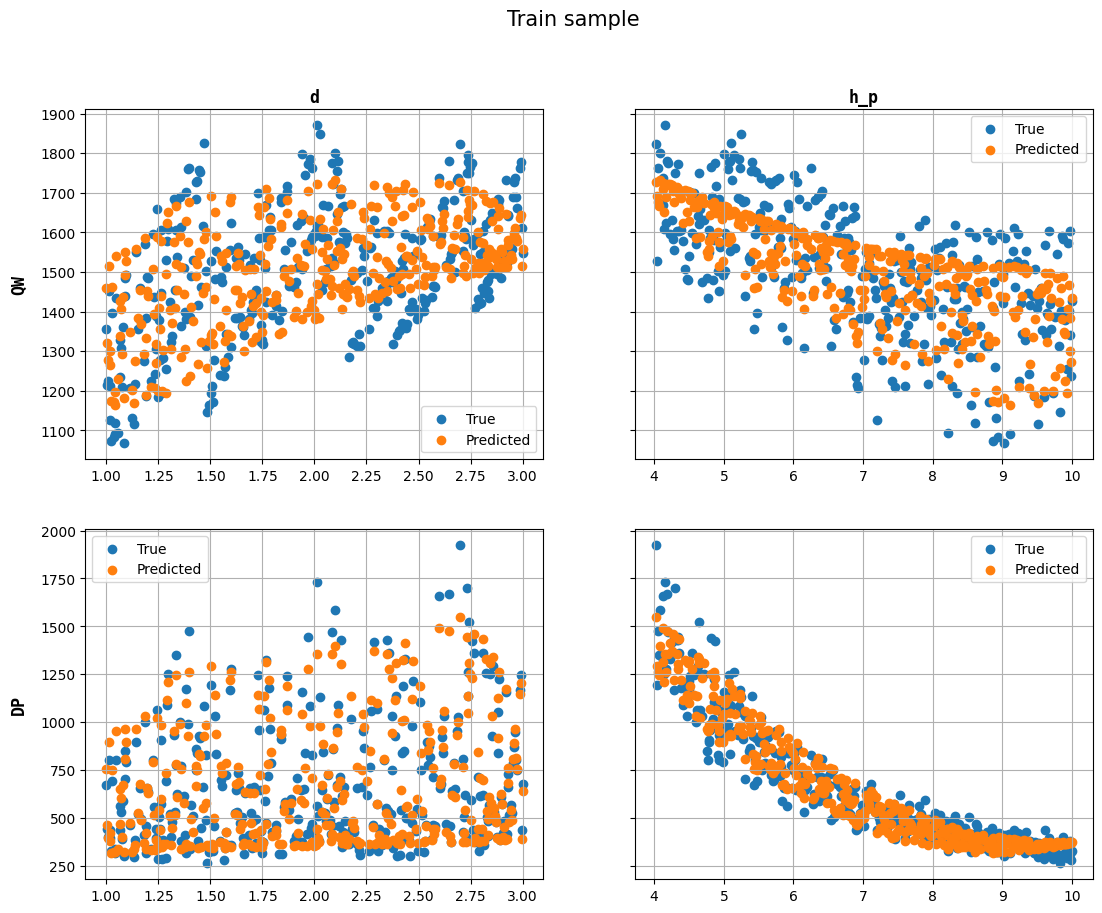

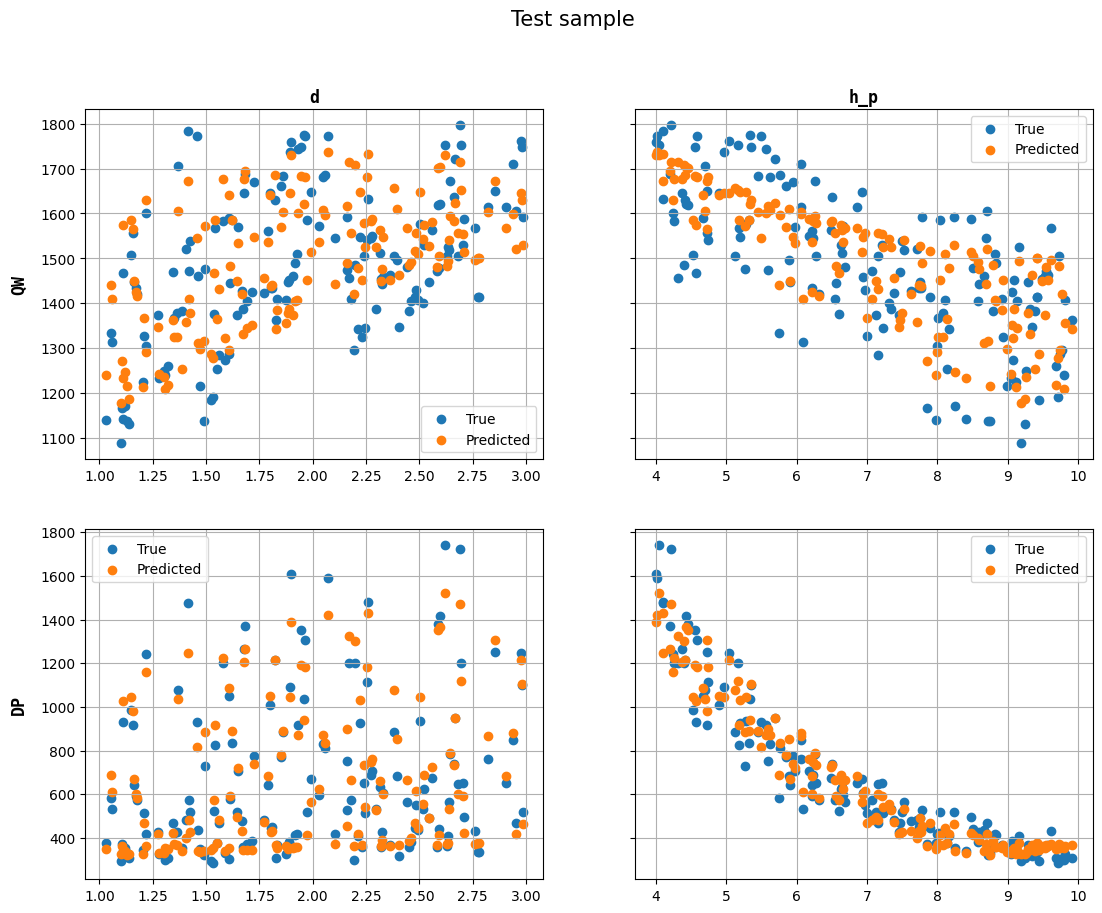

In [23]:
model = Pipeline([
        ("pf", PolynomialFeatures(include_bias=False)),
        ("model", MultiOutputRegressor(Lasso(alpha=0.5)))
    ])

validation.validate_model(
    estimator=model,
    data=data_lasso,
    target_columns=TARGET_COLUMNS,
    show_plots=True
)

### Gradient boosting

In [24]:
from sklearn.model_selection import GridSearchCV

x_train, x_test, y_train, y_test = utils.make_split(data_gb, target_columns=TARGET_COLUMNS)

parameters = {
    'model__base_estimator__learning_rate': [0.01, 0.05, 0.1, 0.2], 
    'model__base_estimator__n_estimators': [25, 50, 100, 200, 300, 500, 1000],
    'model__base_estimator__max_depth': [2, 3, 4, 5],
    'model__base_estimator__n_iter_no_change': [5, 10, 20]
}

model = Pipeline([
    ("pf", PolynomialFeatures(include_bias=False)),
    ("model", RegressorChain(GradientBoostingRegressor(random_state=1), order=[0, 1]))
])
search = GridSearchCV(model, param_grid=parameters, n_jobs=-1, scoring="r2")

search.fit(x_train, y_train)
print(f"Best parameters: {search.best_params_}")
print(f"Test score of best model: {r2_score(y_test, search.best_estimator_.predict(x_test))}")

Best parameters: {'model__base_estimator__learning_rate': 0.2, 'model__base_estimator__max_depth': 2, 'model__base_estimator__n_estimators': 500, 'model__base_estimator__n_iter_no_change': 20}
Test score of best model: 0.9781067287492748


Train-score: 0.994
Test-score: 0.978
CI: (0.969, 0.984), True


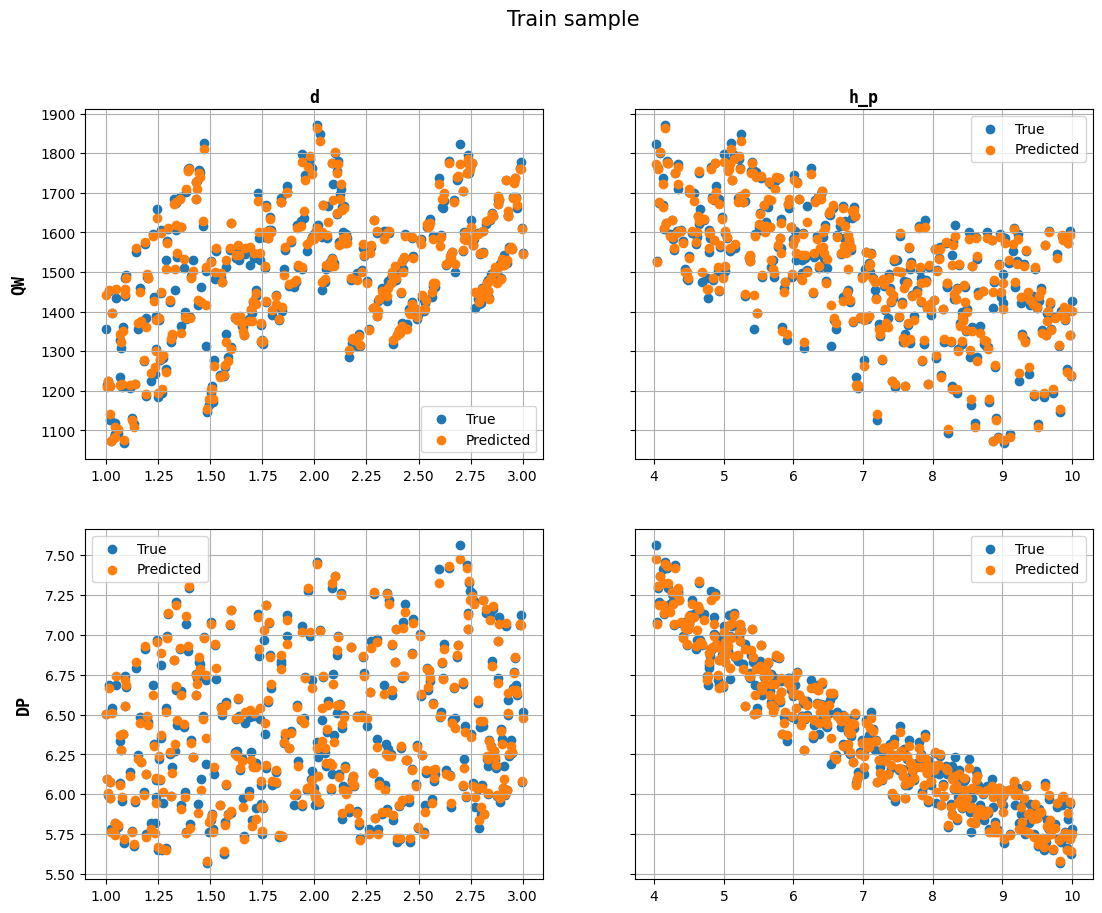

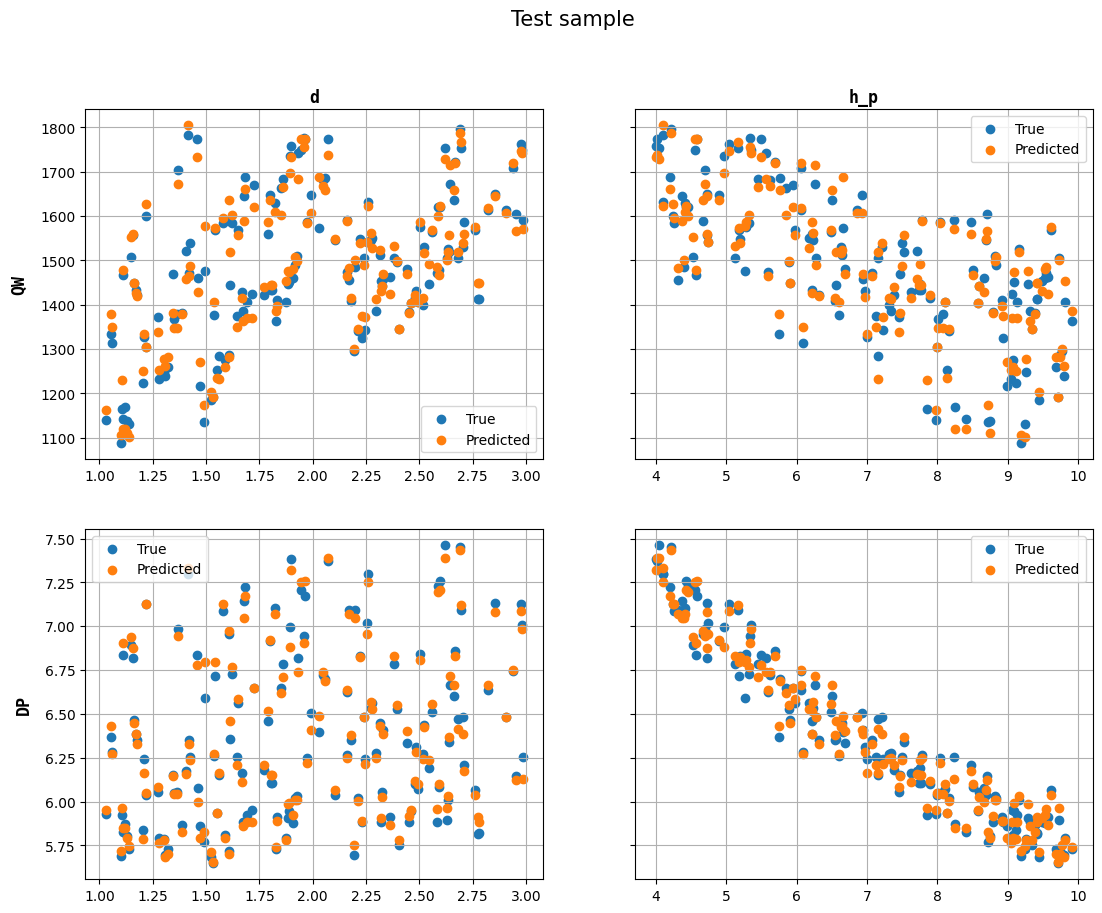

In [25]:
validation.validate_model(
    estimator=search.best_estimator_,
    data=data_gb,
    target_columns=TARGET_COLUMNS,
    show_plots=True
)

## Errors vs number of samples

To estimate generalization ability of the regressors let's try to fit them on a part of train data and make a graph of the obtained errors on the test set against percentage of the data used for training.

In [26]:
def choose_data(x, y, percent):
    n_samples = x.shape[0]
    chosen_idx = np.random.choice(
        n_samples, size=(int(n_samples * percent / 100),), replace=False,
    )
    return x[chosen_idx, :], y[chosen_idx, :]

### Lasso

The graph may slightly vary between runs as random seed is not frozen

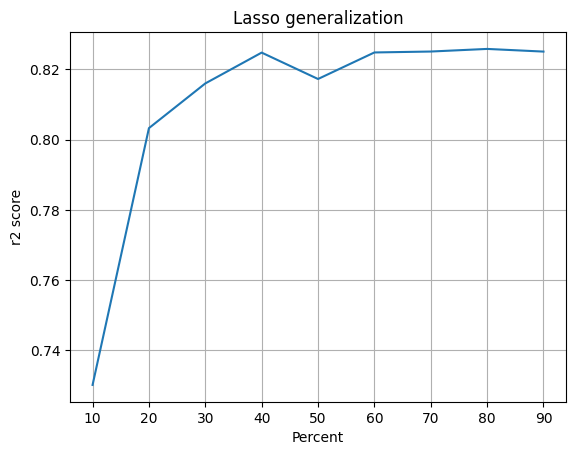

In [27]:
x_train, x_test, y_train, y_test = utils.make_split(data_lasso, target_columns=TARGET_COLUMNS)

percents = np.arange(10, 100, 10)
scores = []

for percent in percents:
    model = Pipeline([
        ("pf", PolynomialFeatures(include_bias=False)),
        ("model", MultiOutputRegressor(Lasso(alpha=0.5)))
    ])
    x_part, y_part = choose_data(x_train, y_train, percent)
    model.fit(x_part, y_part)
    scores.append(r2_score(y_test, model.predict(x_test)))

plt.plot(percents, scores)
plt.grid(True)
plt.title("Lasso generalization")
plt.xlabel("Percent")
plt.ylabel("r2 score")
plt.savefig("fig1")
plt.show()

### Gradient Boosting

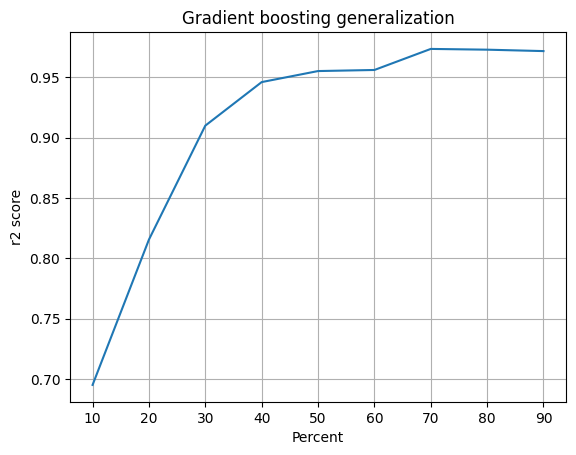

In [28]:
x_train, x_test, y_train, y_test = utils.make_split(data_gb, target_columns=TARGET_COLUMNS)

percents = np.arange(10, 100, 10)
scores = []

for percent in percents:
    model = search.best_estimator_
    x_part, y_part = choose_data(x_train, y_train, percent)
    model.fit(x_part, y_part)
    scores.append(r2_score(y_test, model.predict(x_test)))

plt.plot(percents, scores)
plt.grid(True)
plt.title("Gradient boosting generalization")
plt.xlabel("Percent")
plt.ylabel("r2 score")
plt.savefig("fig2")
plt.show()

### Findings
(Graphs may slightly vary between different runs)

* 30% of the training data (70 samples) is enough to reach r2_score higher than 0.9 for Gradient Boosting model which is better than Linear model results.
* Both models are quite good in generalisation and their ability to predict good results does not suffer to much with the small number of training samples.
* Gradient boosting model works better than Linear models despite additional manipulation with the data.